In [0]:
# Installs the umap dependency
!pip install umap-learn

In [0]:
import numpy as np
import pandas as pd

deleteome_csv_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/deleteome_responsive_mutants_ex_wt_var_controls.txt"
deleteome_dataframe = pd.read_csv(deleteome_csv_path,delimiter='\t',skiprows=[1])
deleteome_dataframe.head()

,reporterId,systematicName,geneSymbol,vps25-del vs. wt,vps25-del vs. wt.1,vps25-del vs. wt.2,opi3-del vs. wt,opi3-del vs. wt.1,opi3-del vs. wt.2,cho2-del vs. wt,cho2-del vs. wt.1,cho2-del vs. wt.2,ctk1-del vs. wt,ctk1-del vs. wt.1,ctk1-del vs. wt.2,hpa1-del-matA vs. wt-matA,hpa1-del-matA vs. wt-matA.1,hpa1-del-matA vs. wt-matA.2,nup133-del-matA vs. wt-matA,nup133-del-matA vs. wt-matA.1,nup133-del-matA vs. wt-matA.2,ctf8-del vs. wt,ctf8-del vs. wt.1,ctf8-del vs. wt.2,doa4-del vs. wt,doa4-del vs. wt.1,doa4-del vs. wt.2,bre2-del-matA vs. wt-matA,bre2-del-matA vs. wt-matA.1,bre2-del-matA vs. wt-matA.2,swd1-del-matA vs. wt-matA,swd1-del-matA vs. wt-matA.1,swd1-del-matA vs. wt-matA.2,spp1-del-matA vs. wt-matA,spp1-del-matA vs. wt-matA.1,spp1-del-matA vs. wt-matA.2,set1-del-matA vs. wt-matA,set1-del-matA vs. wt-matA.1,set1-del-matA vs. wt-matA.2,hfi1-del-matA vs. wt-matA,...,bck1-del vs. wt.2,chk1-del vs. wt,chk1-del vs. wt.1,chk1-del vs. wt.2,ykl161c-del vs. wt,ykl161c-del vs. wt.1,ykl161c-del vs. wt.2,ptc4-del vs. wt,ptc4-del vs. wt.1,ptc4-del vs. wt.2,rim15-del vs. wt,rim15-del vs. wt.1,rim15-del vs. wt.2,cmk2-del vs. wt,cmk2-del vs. wt.1,cmk2-del vs. wt.2,lcb5-del vs. wt,lcb5-del vs. wt.1,lcb5-del vs. wt.2,cka1-del vs. wt,cka1-del vs. wt.1,cka1-del vs. wt.2,psr1-del vs. wt,psr1-del vs. wt.1,psr1-del vs. wt.2,ppg1-del vs. wt,ppg1-del vs. wt.1,ppg1-del vs. wt.2,usa1-del vs. wt,usa1-del vs. wt.1,usa1-del vs. wt.2,wt-matA vs wt,wt-matA vs wt.1,wt-matA vs wt.2,wt-by4743 vs. wt,wt-by4743 vs. wt.1,wt-by4743 vs. wt.2,wt-ypd vs. wt,wt-ypd vs. wt.1,wt-ypd vs. wt.2
0,SCAB000001,Q0010,Q0010,5.823057,0.035863,0.813902,5.740183,-0.040396,0.397733,5.702055,-0.058408,0.214450,6.023311,-0.176650,4.659530e-02,5.723257,0.045415,0.653900,5.592738,-0.002167,0.984596,5.501411,-0.017528,0.863171,5.697973,0.027805,0.819931,5.651613,0.006521,9.561280e-01,5.738315,0.007683,0.958054,6.161692,-0.036948,0.793268,5.755787,-0.026575,0.796772,5.966786,...,0.838578,5.741001,-0.029001,0.871099,5.749001,-0.045000,0.941312,5.739000,0.049798,0.917514,5.745999,-0.045099,0.823648,5.739999,0.016796,0.976665,5.751001,0.020001,0.938203,5.744000,0.011696,0.988483,5.742001,0.029107,0.921108,5.741001,0.042896,0.999352,5.739000,-0.014000,0.980460,5.641819,-0.017202,0.265474,5.768842,0.008386,0.912020,5.600768,-0.029101,0.616744
1,SCAB000002,Q0017,Q0017,5.864305,0.031833,0.788110,5.714900,-0.061949,0.156009,5.714209,-0.032521,0.485448,6.079087,-0.100209,1.620640e-01,5.762339,-0.006401,0.968191,5.642395,-0.016251,0.777781,5.545142,-0.035365,0.651948,5.725384,-0.015726,0.869628,5.688293,-0.052527,6.655940e-01,5.743048,-0.093276,0.432495,6.281474,-0.082750,0.734270,5.770623,-0.070279,0.502252,6.009262,...,0.538481,5.781000,0.022503,0.873952,5.787001,-0.034700,0.931283,5.779000,0.042294,0.909211,5.781000,0.019303,0.913876,5.779999,-0.015600,0.975075,5.789000,-0.027800,0.866674,5.783001,-0.009200,0.988483,5.781000,-0.011200,0.964628,5.782001,0.019104,0.999352,5.779000,-0.032200,0.904008,5.651873,-0.011236,0.417339,5.845863,0.010049,0.897931,5.602166,-0.012800,0.835180
2,SCAB000003,Q0032,Q0032,5.824237,-0.036730,0.799512,5.858313,-0.053242,0.459498,5.916502,-0.120856,0.090443,6.484551,-0.433867,4.205630e-05,5.844414,-0.029716,0.896489,5.717718,0.071392,0.383363,5.593456,-0.029463,0.845980,5.804811,-0.045053,0.684209,5.766628,0.015440,9.208990e-01,5.849595,-0.020263,0.902186,6.088814,-0.031206,0.873557,5.833314,-0.018288,0.895674,6.182386,...,0.867194,5.851999,-0.004100,0.984510,5.858000,-0.084201,0.766966,5.847999,-0.011700,0.985846,5.851999,0.133695,0.307137,5.851000,0.020996,0.972322,5.863001,-0.039300,0.837212,5.853000,0.058594,0.906340,5.851000,0.009405,0.975675,5.851000,0.048404,0.999352,5.849001,-0.011700,0.982628,5.752928,-0.012401,0.568422,5.865916,0.013855,0.905891,5.672766,-0.007500,0.943031
3,SCAB000004,Q0045,COX1,6.814895,-0.214972,0.148581,6.175338,-0.096895,0.135788,6.787510,-0.251795,0.000080,7.480544,0.713361,8.002070e-10,6.722785,0.076600,0.733213,6.600413,0.241511

In [0]:
# Convert to numpy
deleteome_feature_matrix = deleteome_dataframe.iloc[:,3:-1].to_numpy()
print(deleteome_feature_matrix[0])

[ 5.8230566   0.03586317  0.813902   ...  0.91202     5.6007679
 -0.02910071]


Defining UMAP parameters

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap

# Using the same parameters used in the paper
metric = 'cosine'
n_neighbors = 10
min_dist = 0.05
n_components = 2
reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    metric=metric)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Computes UMAP embedding (Takes about 30 seconds)

In [0]:
embedding = reducer.fit_transform(deleteome_feature_matrix)

In [0]:
print(embedding.shape)
print(embedding)

(6123, 2)
[[14.126339   0.5566864]
 [14.194224   0.5140868]
 [14.078802   0.5717247]
 ...
 [ 9.743314  11.321952 ]
 [ 8.171817   5.9310575]
 [ 4.676471   8.482764 ]]


Plot the clusteres (Same color = Same cluster)

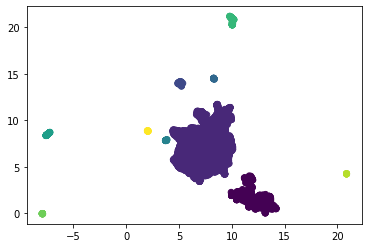

Number of Clusters: 
10
Cluster 0, number of genes: 902
Cluster 1, number of genes: 4835
Cluster 2, number of genes: 91
Cluster 3, number of genes: 19
Cluster 4, number of genes: 23
Cluster 5, number of genes: 99
Cluster 6, number of genes: 104
Cluster 7, number of genes: 25
Cluster 8, number of genes: 9
Cluster 9, number of genes: 16


In [0]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5, min_samples=2).fit(embedding)
total_clusters = len(np.unique(clustering.labels_))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embedding[:,0], embedding[:,1], c=clustering.labels_)
plt.show()

def get_cluster(cluster_num:int):
  return embedding[np.where(clustering.labels_ == cluster_num)]

print("Number of Clusters: ")
print(total_clusters)
for i in range(total_clusters):
  print("Cluster {c_num}, number of genes: {g_num}".format(c_num=i,g_num=len(get_cluster(i))))

Check what complexes are in the Kemmeren Concensus

In [0]:
kemmeren_concensus_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/Kemmeren_Consensus.csv"
kemmeren_concensus_dataframe = pd.read_csv(kemmeren_concensus_path)
kemmeren_concensus_dataframe.head()

,complex_name,source,complex_members_sys,complex_members_short,known_in_GO,known_in_lit,comments,pubmed
0,Spp381-Prp38 complex,curated consensus,YBR152W; YGR075C,SPP381; PRP38,NO,YES,genetic interaction + two-hybrid interaction,9858581
1,Asf1-Rad53 complex,curated consensus,YJL115W; YPL153C,ASF1; RAD53,NO,YES,NaN,11331602; 11172707
2,Pan1-End3 complex,curated consensus,YIR006C; YNL084C,PAN1; END3,NO,YES,NaN,9234686
3,Sod1-Css1 heterodimer,curated consensus,YJR104C; YMR038C,SOD1; CCS1,NO,YES,NaN,11101286
4,HAT-A4 complex,curated consensus,YBR010W; YBR009C; YNL030W; YEL056W; YPL001W; Y...,HHT1; HHF1; HHF2; HAT2; HAT1; HIF1; PSH1; HHT2,NO,YES,NaN,9575221


Defining helper functions to check if any subsets of clusters are in the same complex

In [0]:
def get_cluster_genes(cluster_num:int):
  return deleteome_dataframe.iloc[np.where(clustering.labels_ == cluster_num)[0].tolist(),1].to_numpy()

from itertools import chain, combinations
# Returns a list of all subsets of size lower to upper (inclusive)
def get_all_subsets(iterable,lower,upper):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(lower,upper+1)))

# Given a tuple, check if it is part of a complex 
def is_hit(subset):
  #print("Checking subset {s}".format(s=str(subset)))
  all_complexes = kemmeren_concensus_dataframe.iloc[:,2].to_numpy()
  for i in range(len(all_complexes)):
    hit_num = 0
    for j in range(len(subset)):
      if subset[j] in all_complexes[i]:
        hit_num += 1
    if (hit_num == len(subset)):
      print("{p} is a part of the {c_name} at row {row_num} with subunits {sub}".format(p=str(subset),c_name=kemmeren_concensus_dataframe.iloc[i,0],row_num=i,sub=kemmeren_concensus_dataframe.iloc[i,2]))
      return True
  return False

def check_cluster_with_subset_size(cluster_genes,subset_size):
  subsets = get_all_subsets(cluster_genes,subset_size,subset_size)
  print("Number of subsets of size {size} in this cluster: {num}".format(size=subset_size,num=len(subsets)))
  total_hits = 0
  for subset in subsets:
    if(is_hit(subset)):
      total_hits += 1
  print("Total subsets of size {size} hits: {num}".format(size=subset_size,num=total_hits))
  return total_hits

Case studies: Check if any subsets of size 2 hits in Cluster 4

In [0]:
cluster_4_genes = get_cluster_genes(4)
print("Total amount of genes in this cluster: {n}".format(n=len(cluster_4_genes)))
print()
cluster_4_genes_subset_2_total_hits = check_cluster_with_subset_size(cluster_4_genes,2)
# Size 2 Hit rate: 0.0118577075
print()
cluster_4_genes_subset_3_total_hits = check_cluster_with_subset_size(cluster_4_genes,3)

Total amount of genes in this cluster: 23

Number of subsets of size 2 in this cluster: 253
('YHR005C', 'YJR086W') is a part of the heterotrimeric G-protein complex (GO) at row 439 with subunits YHR005C; YJR086W; YOR212W
('YHR005C', 'YOR212W') is a part of the heterotrimeric G-protein complex at row 127 with subunits YHR005C; YOR212W
('YJR086W', 'YOR212W') is a part of the heterotrimeric G-protein complex (GO) at row 439 with subunits YHR005C; YJR086W; YOR212W
Total subsets of size 2 hits: 3

Number of subsets of size 3 in this cluster: 1771
('YHR005C', 'YJR086W', 'YOR212W') is a part of the heterotrimeric G-protein complex (GO) at row 439 with subunits YHR005C; YJR086W; YOR212W
Total subsets of size 3 hits: 1


Same with cluster 6

In [0]:
cluster_6_genes = get_cluster_genes(6)
print("Total amount of genes in this cluster: {n}".format(n=len(cluster_6_genes)))
# Hit rate: 0.00056011949
print()
cluster_6_genes_subset_2_total_hits = check_cluster_with_subset_size(cluster_6_genes,2)

Total amount of genes in this cluster: 104

Number of subsets of size 2 in this cluster: 5356
('YBR109C', 'YOR326W') is a part of the putative Cmd1-Mlc1-Myo2-Myo1-Mlc2 complex at row 334 with subunits YBR109C; YGL106W; YOR326W; YHR023W; YPR188C
('YFL007W', 'YJL001W') is a part of the proteasome core complex at row 191 with subunits YFL007W; YER012W; YGL011C; YBL041W; YOL038W; YFR050C; YGR135W; YER094C; YJL001W; YOR362C; YPR103W; YGR253C; YML092C; YOR157C; YMR314W
('YHR039C-A', 'YOR332W') is a part of the vacuolar proton-transporting V-type ATPase, V1 domain at row 151 with subunits YJR033C; YDL185W; YBR127C; YGR020C; YHR039C-A; YEL051W; YPR036W; YOR332W; YKL080W
Total subsets of size 2 hits: 3


Cluster 2

In [0]:
cluster_2_genes = get_cluster_genes(2)
print("Total amount of genes in this cluster: {n}".format(n=len(cluster_2_genes)))
print()
cluster_2_genes_subset_2_total_hits = check_cluster_with_subset_size(cluster_2_genes,2)

Total amount of genes in this cluster: 91

Number of subsets of size 2 in this cluster: 4095
('YAL016W', 'YML109W') is a part of the protein phosphatase type 2A complex at row 110 with subunits YAL016W; YDL188C; YGL190C; YDL134C; YMR273C; YML109W; YOR014W
('YFL038C', 'YLR262C') is a part of the putative Gdi1-Ypt6-Ypt1 complex at row 383 with subunits YER136W; YLR262C; YFL038C
Total subsets of size 2 hits: 2


In [0]:
# Control
all_unique_gene = np.unique(deleteome_dataframe.iloc[:,1].to_numpy())

def generate_pairs(total_pairs):
  to_return = []
  print("Sampling...")
  for row in np.random.choice(all_unique_gene,(total_pairs,2)):
    gene1 = row[0]
    gene2 = row[1]
    if gene1 == gene2:
      new_choices = np.random.choice(all_unique_gene,2,replace=False)
      gene1 = new_choices[0]
      gene2 = new_choices[1]
    to_return.append((gene1,gene2))
  return to_return

control_cluster = generate_pairs(100000)
control_total_hits = 0
for subset in control_cluster:
  if(is_hit(subset)):
    control_total_hits += 1
print("Total hit in control cluster of size {s}: {h}".format(s=len(control_cluster),h=control_total_hits))
# about 0.00051 hit rate




Sampling...
('YDR490C', 'YGR086C') is a part of the putative Pkh1-Mrp8-Pil1-Lsp1 complex at row 394 with subunits YDR490C; YKL142W; YGR086C; YPL004C
('YGL123W', 'YBL027W') is a part of the cytosolic large ribosomal subunit at row 218 with subunits YBL092W; YGL014W; YBR191W; YHR141C; YLR287C-A; YFR032C-A; YGR118W; YNL302C; YNL096C; YGL031C; YDR418W; YGL123W; YDR382W; YDL083C; YCR031C; YDR447C; YER074W; YBL027W; YDL136W; YHL001W; YJL177W; YGR034W; YMR194W; YKL180W; YBR181C; YOL040C; YHL033C; YFR031C-A; YNL069C; YML073C; YLR448W; YNL301C; YLR075W; YML063W; YLR441C; YJR123W; YNL178W; YPL090C; YLR150W; YGL147C; YBR031W; YGL030W; YDL075W; YGL103W; YDL082W; YDR471W; YMR242C; YOL127W; YGL135W; YGR085C; YIL133C; YLR029C; YDR012W; YOR312C; YGL076C; YLL045C; YOR063W; YPL198W; YPL249C-A; YLR340W; YIL018W; YPL220W; YMR142C; YOL039W
('YPR137W', 'YPL126W') is a part of the 90S preribosome at row 169 with subunits YBR247C; YDR324C; YPL126W; YOR310C; YGR145W; YLR222C; YNL075W; YJL109C; YDR398W; YCR057C